<a href="https://colab.research.google.com/github/hunainahmedj/TorchVision-Detection-Segmentation-Finetuning/blob/main/TorchVision_Detection_%26_Segmentation_Finetunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt

import torch
from torchvision.io import read_image

## Downloading The PennFudanPed Dataset

In [1]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data; cd data; unzip PennFudanPed.zip

--2024-09-21 14:59:24--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘data/PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  34.0MB/s    in 1.5s    

2024-09-21 14:59:26 (34.0 MB/s) - ‘data/PennFudanPed.zip’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPe

## Exploring The Dataset

In [5]:
DATA_DIR = "data/PennFudanPed"

In [16]:
print(f'Dataset size: {len([image for image in listdir(join(DATA_DIR, "PNGImages")) if isfile(join(DATA_DIR, "PNGImages", image))])}')

Dataset size: 170


torch.Size([3, 430, 569]) torch.Size([1, 430, 569])


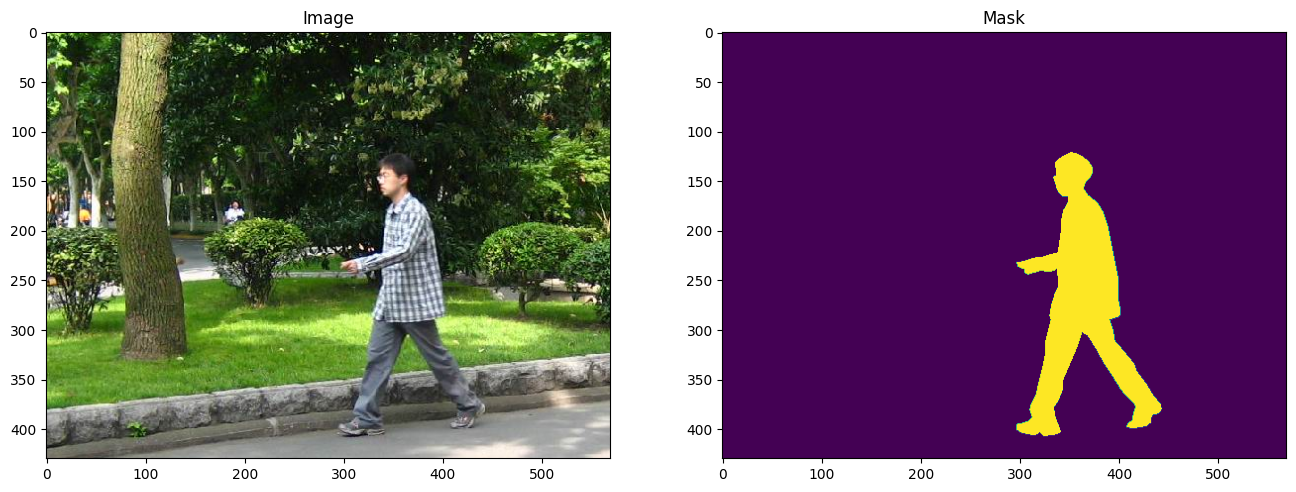

In [17]:
image = read_image("data/PennFudanPed/PNGImages/FudanPed00031.png") # => torch.Tensor(channels, height, width)
mask = read_image("data/PennFudanPed/PedMasks/FudanPed00031_mask.png") # => torch.Tensor(channels, height, width)

print(image.shape, mask.shape)

plt.figure(figsize=(16, 8))

plt.subplot(121) # (row, column, index) => (1 row, 2 columns, 1st index)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0)) # Re-ordering the image to (height, width, channels)

plt.subplot(122) # (row, column, index) => (1 row, 2 columns, 1st index)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0)) # Re-ordering the image to (height, width, channels)
plt.show()

In [14]:
torch.unique(mask), len(torch.unique(mask)) - 1 # getting all the object instances in the image (0 is for background)


(tensor([0, 1], dtype=torch.uint8), 1)

## Creating Custom PyTorch Dataset Class

In [18]:
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors # just like regular tensors (they are tensors), they are needed in torchvision.transforms.v2.
from torchvision.transforms.v2 import functional as F

class PennFudanDataset(torch.utils.data.Dataset):
  def __init__(self, root, transforms):
    self.root = root
    self.transforms = transforms

    self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
    self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

  def __getitem__(self, idx):
    # load images and masks
    img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
    mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
    img = read_image(img_path)
    mask = read_image(mask_path)

    # instances of target objects are encoded with different colors in the mask, each instance has a unique color (out of which its mask is made of)
    obj_ids = torch.unique(mask)
    obj_ids = obj_ids[1:] # Remove the background
    num_objs = len(obj_ids)

    masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

    boxes = masks_to_boxes(masks) # generate bounding boxes from masks of instances

    labels = torch.ones((num_objs,), dtype=torch.int64)

    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    img = tv_tensors.Image(img)

    target = dict(
        image_id = idx,
        labels = labels,
        masks = tv_tensors.Mask(masks),
        boxes = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img)),
        area = area,
        iscrowd = iscrowd
    )

    # target = {}
    # target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
    # target["masks"] = tv_tensors.Mask(masks)
    # target["labels"] = labels
    # target["image_id"] = idx
    # target["area"] = area
    # target["iscrowd"] = iscrowd

    if self.transforms is not None:
      img, target = self.transforms(img, target)


    return img, target

  def __len__(self):
    return len(self.imgs)




## Configuring The Model

Mask R-CNN builds upon Faster R-CNN,the "***box predictor***" is responsible for object detection. It returns:

*   Bounding Boxes
*   Class Labels

ROI (Region of Interest): The network generates proposals for regions that are likely to contain objects. This is done using the **Region Proposal Network (RPN)**. After the proposal the features are extracted from these regions using **ROI Pooling**

ROI Heads: After the extraction of the features, **ROI Heads** take over (Bounding Box Head, Mask Head). The box head predicts the class and the bounding box, and the mask head predicts the pixel-level mask. They operate in parralel


In [19]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):

  # load the instance segmentation model
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT") # trained on COCO

  # get number of input features for the class
  # cls_score (layer): this is the classification scores for each object class from the fully connected layer
  # for instance in the default COCO-trained Mask R-CNN, cls_score would predict the probability of an object being one of the 91 classes in COCO (e.g., car, person, dog, etc.).
  in_features = model.roi_heads.box_predictor.cls_score.in_features # get the input features this layer expects (number of features coming from the earlier layer to this classification layer)
  # we do this because we need to replace the box predictor with a new one, and we need to know how many input features this 'classification' layer expects so we can configure the new predictor

  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


  # mask prediction branch has a conv layer 'conv5_mask'.
  # this processes the region proposals (generated by the detection branch) and produces the final mask
  in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels # how many feature maps are coming into that layer
  hidden_layer = 256

  model.roi_heads.mask_predictor = MaskRCNNPredictor(
      in_features_mask,
      hidden_layer,
      num_classes
  )

  return model

In [20]:
from torchvision.transforms import v2 as T

def get_transform(train):
  transforms = []
  if train:
    transforms.append(T.RandomHorizontalFlip(0.5)) # helps improve the generalization ability of the model
  transforms.append(T.ToDtype(torch.float, scale=True))
  transforms.append(T.ToPureTensor()) # converts the PIL image or Numpy array to PyTorch tensor
  return T.Compose(transforms)

In [21]:
%%bash
wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py -q
wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py -q
wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py -q
wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py -q
wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py -q

In [22]:
import utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)
print(output)

model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)
print(predictions[0])

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:03<00:00, 49.2MB/s]


{'loss_classifier': tensor(0.1357, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0485, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0066, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0062, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


## Setting Up Dataloader and Train Loop

In [23]:
from engine import train_one_epoch, evaluate

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))

indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# training and test dataloaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

model = get_model_instance_segmentation(num_classes)

model.to(device) # moving the model to the appropiate device

# contructing Sto Gradient Descent as optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 172MB/s]
/content/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/60]  eta: 0:03:13  lr: 0.000090  loss: 3.7368 (3.7368)  loss_classifier: 0.5378 (0.5378)  loss_box_reg: 0.1873 (0.1873)  loss_mask: 2.9965 (2.9965)  loss_objectness: 0.0134 (0.0134)  loss_rpn_box_reg: 0.0018 (0.0018)  time: 3.2300  data: 0.0306  max mem: 2151
Epoch: [0]  [10/60]  eta: 0:00:37  lr: 0.000936  loss: 1.1632 (2.2392)  loss_classifier: 0.3438 (0.3554)  loss_box_reg: 0.2280 (0.2354)  loss_mask: 0.6941 (1.6246)  loss_objectness: 0.0189 (0.0206)  loss_rpn_box_reg: 0.0026 (0.0032)  time: 0.7560  data: 0.0275  max mem: 2797
Epoch: [0]  [20/60]  eta: 0:00:26  lr: 0.001783  loss: 1.0072 (1.5914)  loss_classifier: 0.2197 (0.2846)  loss_box_reg: 0.2464 (0.2536)  loss_mask: 0.4206 (1.0171)  loss_objectness: 0.0258 (0.0283)  loss_rpn_box_reg: 0.0056 (0.0078)  time: 0.5301  data: 0.0299  max mem: 3041
Epoch: [0]  [30/60]  eta: 0:00:18  lr: 0.002629  loss: 0.6673 (1.2521)  loss_classifier: 0.1131 (0.2204)  loss_box_reg: 0.2516 (0.2361)  loss_mask: 0.2740 (0.7659)  loss_ob

In [ ]:
# set the number of epochs
num_epochs = 2

for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
  lr_scheduler.step()
  evaluate(model, data_loader_test, device=device)

print("That's it!")

## Inference

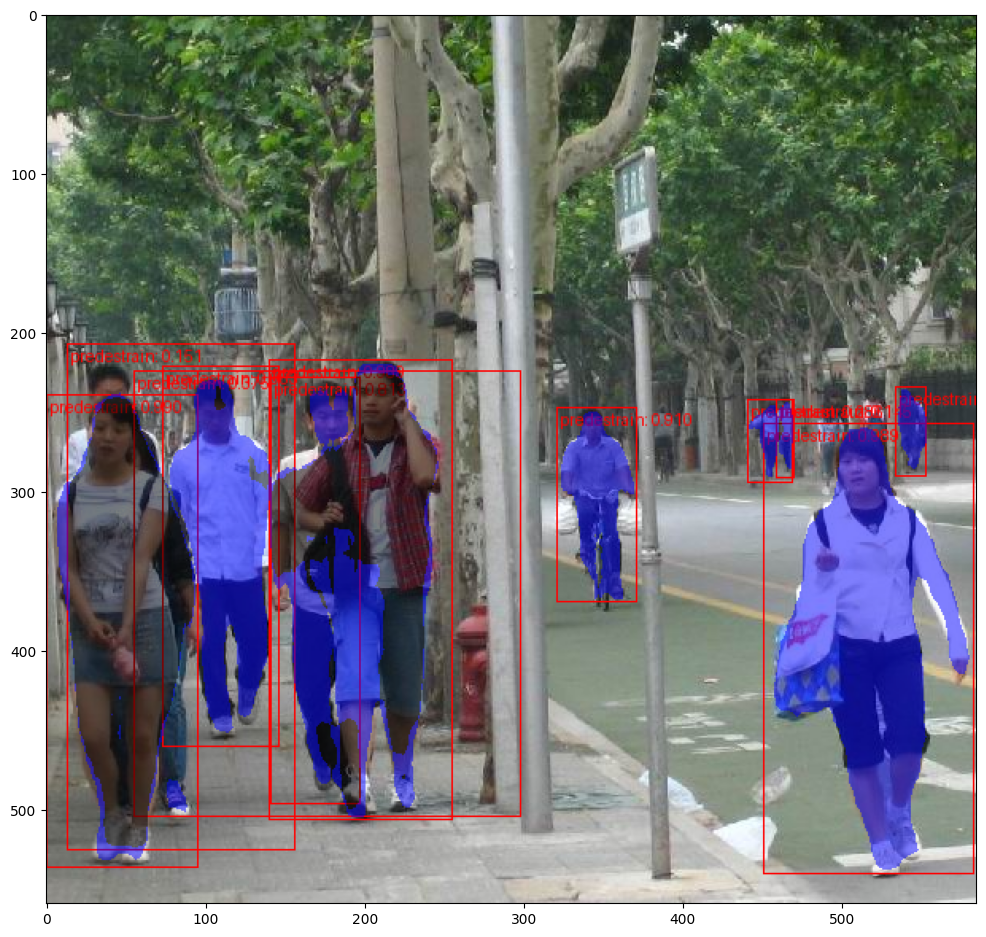

In [30]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

image = read_image(join(DATA_DIR, "PNGImages", "FudanPed00048.png"))
eval_transform = get_transform(train=False)

model.eval()

with torch.no_grad():
  x = eval_transform(image)

  x = x[:3, ...].to(device) # select only the first 3 channels (i.e., RGB). The ... ensures the selection applies to all dimensions
  predictions = model([x, ]) # the input is in the list because the model expects a batch
  pred = predictions[0] # get the predictions for the first image

# `image.min()` and `image.max()` gets the minimum and maximum pixel values, then the values are normalized, then converted to unit8 (necessary for displaying the iamge)
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8) # image normalization
image = image[:3, ...] # selecting the first three channels
pred_labels = [f"predestrain: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1) # 0.7 threshold, the mask tensor has a shape [N, 1, H, W] (N = number of masks), the squeeze reshapes to [N, H, W]
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1,2,0))
plt.show()